
## ECOPs AFRICA OCEAN COLOUR TRAINING

### M1-L2: Introduction to satellite data concepts and applications
<span style="color:brown; font-size:1.2em;font-style:italic">Working with swath imagery: understanding level-2 flag information </span>
<hr style="border:2px solid rgb(30,70,125)"> </hr>


<span style="font-size:1.1em;">Eligio Maure (maure@npec.or.jp)</span>

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button.   
Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Exercise with MODIS-Aqua](#3.-Exercise-with-MODIS-Aqua)
- [4. Exercise with SGLI/GCOM-C ](#4.-Exercise-with-SGLI/GCOM-C)
- [5. Resources](#5.-Resources)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

The objective of this exercise is to explore the flags that are used to quality control level 2 Ocean Color products. 

These flags define the conditions that make it impossible to calculate any meaningful Level 2 parameters.

You will learn how to read level 2 products and display flag information to understand their impact at the pixel level. 
***

# 2. Library import   
[Return to the "Table of contents"](#Table-of-contents)

Start by importing require modules for this activity   
If a module throws a `ModuleNotFoundError` try installing it with the command  
- `!conda install --channel "conda-forge" module` or with  
- `!pip install module`  

If you have a requirement file containing the names of the modules you want to install, use
- `!pip install -r requirements.txt`

Remove `!` if you run the command directly in your terminal or command prompt.   
For this exercise we created a Python environment using the `environment.yml` file which contains the required module.   
You can also add additional modules to the list.

---

In [1]:
# Data manipulation
import numpy as np
import h5py 
from netCDF4 import Dataset

# System
import sys
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
from matplotlib import colors
from cartopy import crs as ccrs, feature as cfeature

%matplotlib inline

In M1L1 we introduced `Matplotlib`, `h5py`, `sys` and `pathlib`.
Here, two new modules will be introduced, `Numpy` and `Cartopy`.

[NumPy](https://numpy.org/) is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
Cartopy also makes use of the NumPy, Matplotlib and other libraries.

---

- **Local modules**  

Include a local library (scripts) with custom fuctions.  

We use the `sys` module to append a directory to the list of known paths for interpreter to search.  
This allow us to import the custom functions or modules not in the search directories.

We also use the `Path` library to help us get the name of the current working directory.

---

In [2]:
# appending a path
cwd = Path.cwd()
sys.path.append(str(cwd.parent))

# print(cwd.parent)

In [3]:
import octutils as util

# 3. Exercise with MODIS-Aqua
[Return to the "Table of contents"](#Table-of-contents)

In [4]:
# Define and read data (MODIS-Aqua)
files = list(cwd.joinpath('data').glob('A2022*.L2_LAC_OC*'))

with Dataset(files[0], mode='r') as nc:
    geo = nc.groups['navigation_data'] # geolocation
    sds = nc.groups['geophysical_data'] # scientific dataset
    
    lon = geo['longitude'][:]
    lat = geo['latitude'][:]
    l2_flags = sds['l2_flags'][:]
    chlor_a = sds['chlor_a'][:]
    flag_meanings = sds['l2_flags'].flag_meanings.split()

- **MODIS-Aqua level-2 flag meaning**  

Short description of each name associated with each bit number can be found at the NASA page about [Level 2 Ocean Color Flags](https://oceancolor.gsfc.nasa.gov/atbd/ocl2flags/).


```javascript
flag_means = {00: 'ATMFAIL',  01: 'LAND',       02: 'PRODWARN', 
              03: 'HIGLINT',  04: 'HILT',       05: 'HISATZEN',
              06: 'COASTZ',   07: 'SPARE',      08: 'STRAYLIGHT', 
              09: 'CLDICE',   10: 'COCCOLITH',  11: 'TURBIDW',
              12: 'HISOLZEN', 13: 'SPARE',      14: 'LOWLW', 
              15: 'CHLFAIL',  16: 'NAVWARN',    17: 'ABSAER', 
              18: 'SPARE',    19: 'MAXAERITER', 20: 'MODGLINT', 
              21: 'CHLWARN',  22: 'ATMWARN',    23: 'SPARE',
              24: 'SEAICE',   25: 'NAVFAIL',    26: 'FILTER', 
              27: 'SPARE',    28: 'BOWTIEDEL',  29: 'HIPOL',
              30: 'PRODFAIL', 31: 'SPARE'};
```

---

- **Define a function to retrieve the flag-bit information**

The same [Level 2 Ocean Color Flags](https://oceancolor.gsfc.nasa.gov/atbd/ocl2flags/) page provides a tool to interactively turn Level 2 flags ON or OFF.   
While turning ON or OFF the flags, the tool is doing bit-shifting behind the scenes.  
We define a function to do the same task, i.e., to tell us where a given bit number is ON in the `l2_flags` array.

In [5]:
def get_flag_mask(bit: int, data):
    """
    1. https://realpython.com/python-bitwise-operators/#left-shift
    2. https://realpython.com/python-bitwise-operators/#bitwise-and
    """
    mask = data & (1 << bit)
    return np.ma.masked_where(mask==0, mask)

- **Explore the L2 flags**

On the left you have the [`l2_flags`](https://oceancolor.gsfc.nasa.gov/atbd/ocl2flags/) and on the right the chlorophyll image.  
Check what flags have made the chlorophyll pixels invalid by changing the `bit` number and observing the resulting image.

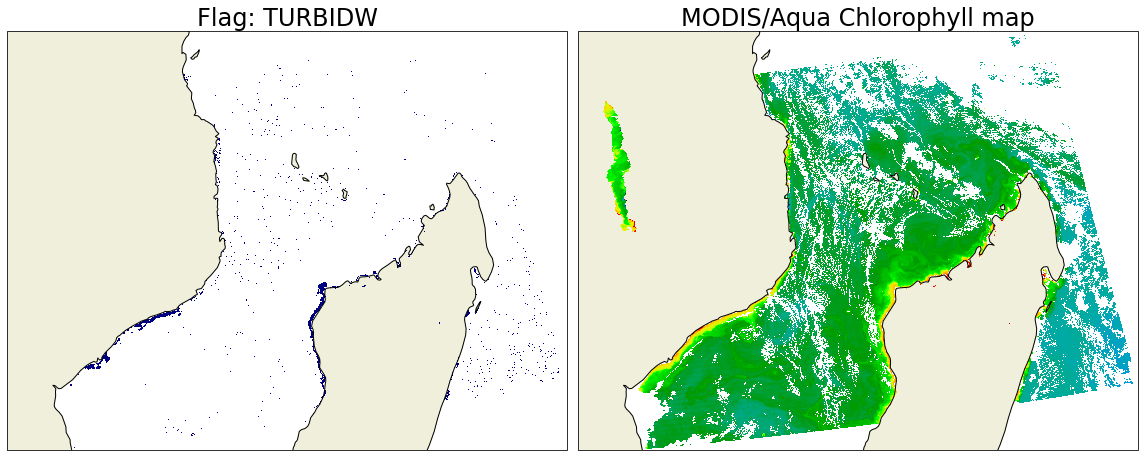

In [6]:
bit = 11
fmask = get_flag_mask(bit=bit, data=l2_flags); 

# initialize map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1,2, figsize=(16, 8), subplot_kw=dict(projection=crs))

# Map displaying the flag information
ax[0].pcolormesh(lon, lat, fmask, shading='auto', cmap='jet')
ax[0].set_title(f'Flag: {flag_meanings[bit]}', size=24)
ax[0].coastlines()
ax[0].add_feature(cfeature.LAND)
# gl = ax[0].gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Map displaying the chlorophyll data
ax[1].pcolormesh(lon, lat, chlor_a, cmap='nipy_spectral', shading='auto', norm=colors.LogNorm())
ax[1].set_title(f'MODIS/Aqua Chlorophyll map', size=24)
ax[1].coastlines()
ax[1].add_feature(cfeature.LAND)
# gl = ax[1].gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()

# 4. Exercise with SGLI/GCOM-C 
[Return to the "Table of contents"](#Table-of-contents)
- Try it - 10 min

- **SGLI/GCOM-C level-2 flag meaning**

```javascript
flag_means = {00: 'DATAMISS',  01: "LAND",
              02: 'ATMFAIL',   03: "CLDICE",
              04: "CLDAFFCTD", 05: "STRAYLIGHT",
              06: "HIGLINT",   07: "MODGLINT",
              08: 'HISOLZ',    09: 'HITAUA',
              10: 'NEGNLW',    11: 'TURBIDW',
              12: 'SHALLOW',   13: "ITERFAILCDOM",
              14: 'CHLWARN',   15: 'SPARE'};
```

In [7]:
# Define and read data
files = list(cwd.joinpath('data').glob(
    'GC1SG1_202205250730*IWPRQ_3000.h5'))

h5 = util.File(files[0], mode='r')
lat, lon = h5.lat, h5.lon
qa_flag = h5.get_data(key='QA_flag')
chla = h5.get_data(key='CHLA')
qa_meanings = h5.get_flag_meanings()
h5.close()

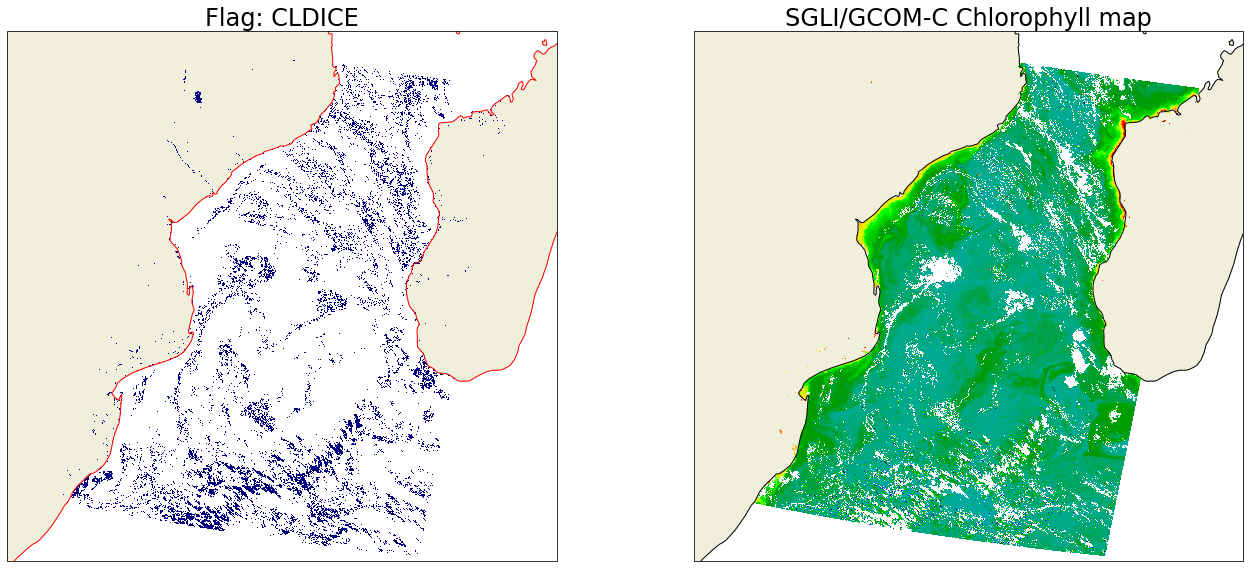

In [8]:
bit = 3
fmask = get_flag_mask(bit=bit, data=qa_flag); 

fig, ax = plt.subplots(1,2, figsize=(20, 8), 
                       subplot_kw=dict(projection=crs),
                       sharey=True)

ax[0].pcolormesh(lon, lat, fmask, shading='auto', cmap='jet')
ax[0].coastlines(color='r')
ax[0].add_feature(cfeature.LAND)
ax[0].set_title(f'Flag: {qa_meanings[bit]}', size=24)

ax[1].pcolormesh(lon, lat, chla, cmap='nipy_spectral', shading='auto', norm=colors.LogNorm())
ax[1].coastlines()
ax[1].add_feature(cfeature.LAND)
ax[1].set_title(f'SGLI/GCOM-C Chlorophyll map', size=24)

plt.tight_layout()

<div class="alert alert-block alert-warning" /div>
    <h3>Task</h3>
    
--- 
    
Indicate which flags invalidate oceanic pixels.   
Why pixels are masked when `CLDICE` is ON.


<div class="alert alert-block alert-info" /div>
<h2>Bonus!</h2>

---

We can also display a color composite image where clouds are more intuitive.   
Using the download methods introduced in previous class, download SGLI `NWLR` data  



In [9]:
files = list(cwd.joinpath('data').glob(
    'GC1SG1_202205250730*_L2SG_NWLRQ_3000.h5'))

h5 = util.File(files[0], mode='r')
b = h5.get_dn(key='NWLR_443')
g = h5.get_dn(key='NWLR_530')
r = h5.get_dn(key='NWLR_670')
extent = h5.get_extent()
h5.close()
    
rgb = np.dstack((r, g, b))

In [10]:
# To see the original dark color composite image uncomment the lines below
# plt.figure(figsize=(15, 20))
# plt.imshow(rgb, extent=extent)

In [11]:
%%time
rgb_enh = np.zeros(r.shape + (3,), dtype=np.uint8)
rgb_enh[:,:,0] = util.enhance_image(image=rgb[:,:,0])
rgb_enh[:,:,1] = util.enhance_image(image=rgb[:,:,1])
rgb_enh[:,:,2] = util.enhance_image(image=rgb[:,:,2])

Wall time: 12.9 s


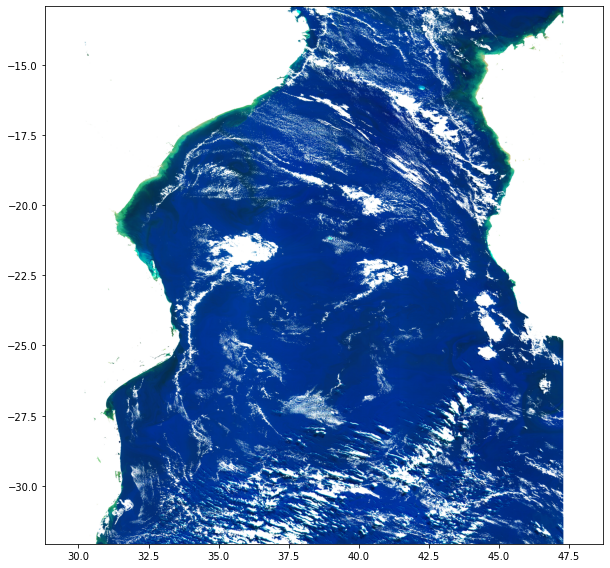

In [12]:
plt.figure(figsize=(10, 15))
plt.imshow(rgb_enh, extent=extent)

<div class="alert alert-block alert-warning" /div>
    <h3>Task</h3>
    
--- 
    
Why the color composite map looks vertical and the chlorophyll map looks oblique?  
Can you think of a reason why MODIS/Aqua image is tilted towards northwest but SGLI/GCOM-C tilted towards northeast? 


<div class="alert alert-block alert-success"/div>
    <h2>Done!</h2>
  
--- 

#### And thank you for your attention! :) 
    We hope you are enjoying the training provided by A-ECOP for A-ECOPs.

# 5. Resources
[Go back to the "Table of contents"](#Table-of-contents)
1. [Level 2 Ocean Color Flags](https://oceancolor.gsfc.nasa.gov/atbd/ocl2flags/)
2. [QA_flag information](https://suzaku.eorc.jaxa.jp/GCOM_C/data/files/ATBD_ocean_ac_murakami_v2_en.pdf)
3. [Cloud flag/Classification](https://suzaku.eorc.jaxa.jp/GCOM_C/data/update/Algorithm_CLFG_en.html)
4. [Matplotlib](https://matplotlib.org/)
5. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/#)
6. [Bright MODIS Images](http://www.idlcoyote.com/ip_tips/brightmodis.html)
7. [ECOPs Ocean Colour Training](https://github.com/Elgyii/ocean-colour-training-ecops-africa)